# Time Series forecasting with Prophet

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import prophet as prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

## Data

The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region.


In [2]:
pjme = pd.read_csv('data/PJME_hourly.csv',
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates


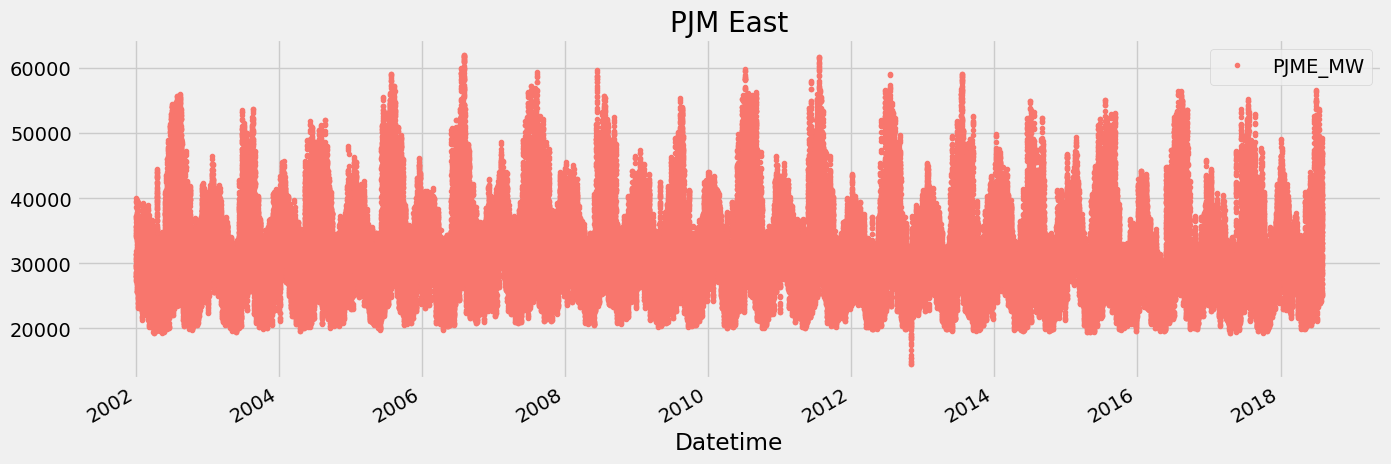

In [3]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

## EDA
We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [4]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

In [5]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


## Plotting the Features to see trends
Power demand has strong daily and seasonal properties.


Day of week also seems to show differences in peaks

/Users/ec/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


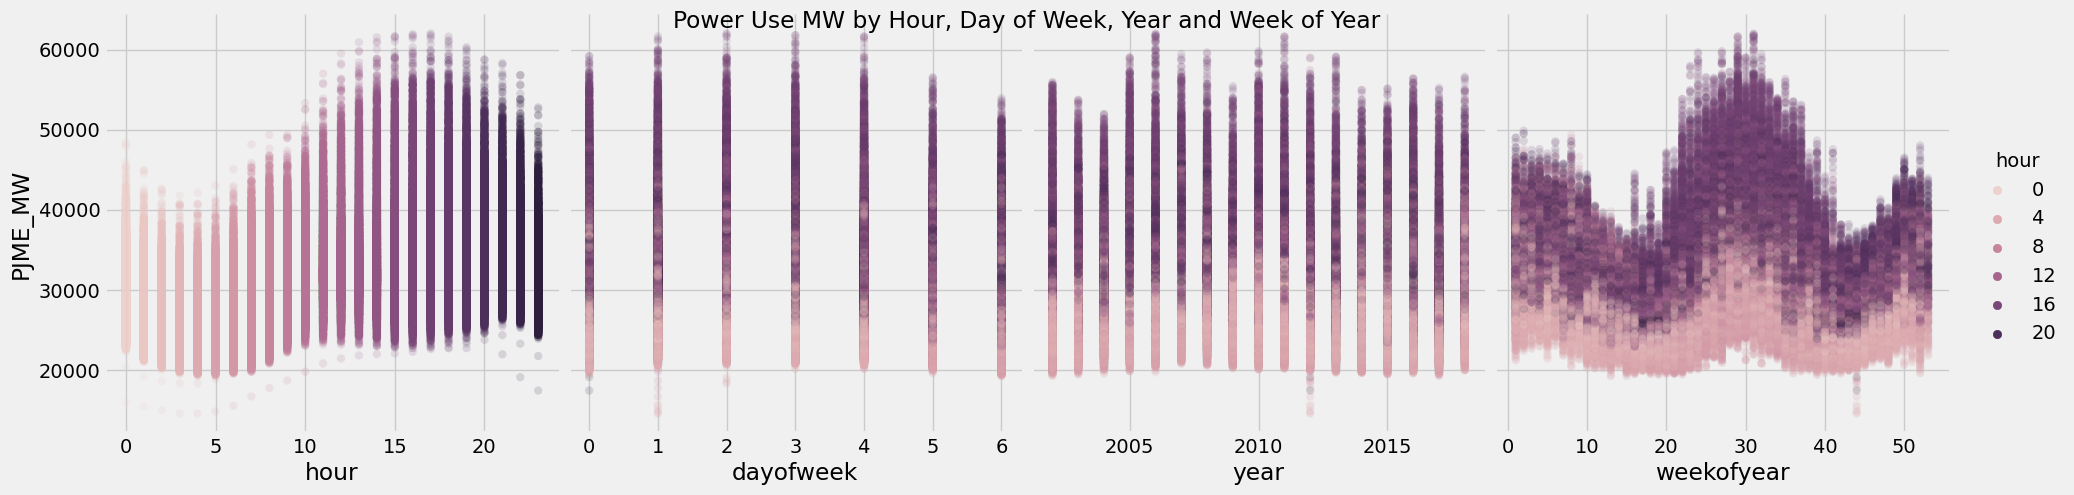

In [6]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

## Train/Test Split

Cut off the data after 2015 to use as our validation set. We will train on earlier data.

In [7]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

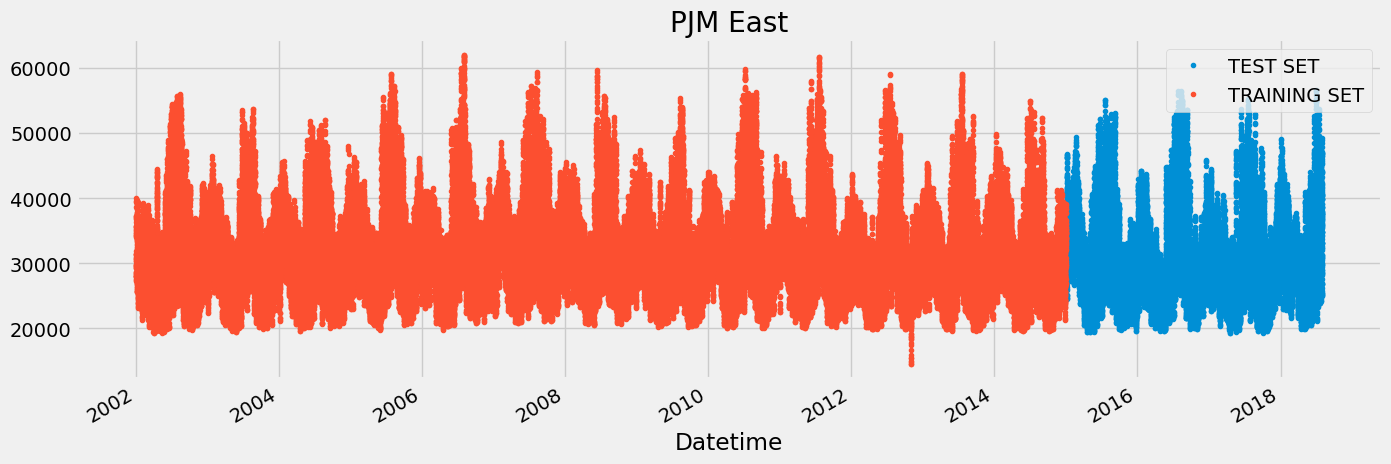

In [8]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

## Prophet Model

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

In [9]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [10]:
# Setup and train model and fit
model = prophet.Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

12:51:03 - cmdstanpy - INFO - Chain [1] start processing
12:52:09 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31201.981348,23951.864609,32877.589051,31201.981348,31201.981348,-2854.446190,-2854.446190,-2854.446190,-4430.339161,...,1281.369753,1281.369753,1281.369753,294.523218,294.523218,294.523218,0.0,0.0,0.0,28347.535158
1,2015-01-01 02:00:00,31201.943346,22297.592843,31435.115766,31201.943346,31201.943346,-4358.771252,-4358.771252,-4358.771252,-5927.206404,...,1272.617499,1272.617499,1272.617499,295.817653,295.817653,295.817653,0.0,0.0,0.0,26843.172095
2,2015-01-01 03:00:00,31201.905344,21603.169459,30399.187446,31201.905344,31201.905344,-5230.477050,-5230.477050,-5230.477050,-6790.290152,...,1262.659492,1262.659492,1262.659492,297.153610,297.153610,297.153610,0.0,0.0,0.0,25971.428294
3,2015-01-01 04:00:00,31201.867342,21459.814181,30233.929556,31201.867342,31201.867342,-5372.095148,-5372.095148,-5372.095148,-6922.245515,...,1251.619252,1251.619252,1251.619252,298.531115,298.531115,298.531115,0.0,0.0,0.0,25829.772194
4,2015-01-01 05:00:00,31201.829340,21873.126450,31061.299669,31201.829340,31201.829340,-4697.831866,-4697.831866,-4697.831866,-6237.414569,...,1239.632510,1239.632510,1239.632510,299.950193,299.950193,299.950193,0.0,0.0,0.0,26503.997473


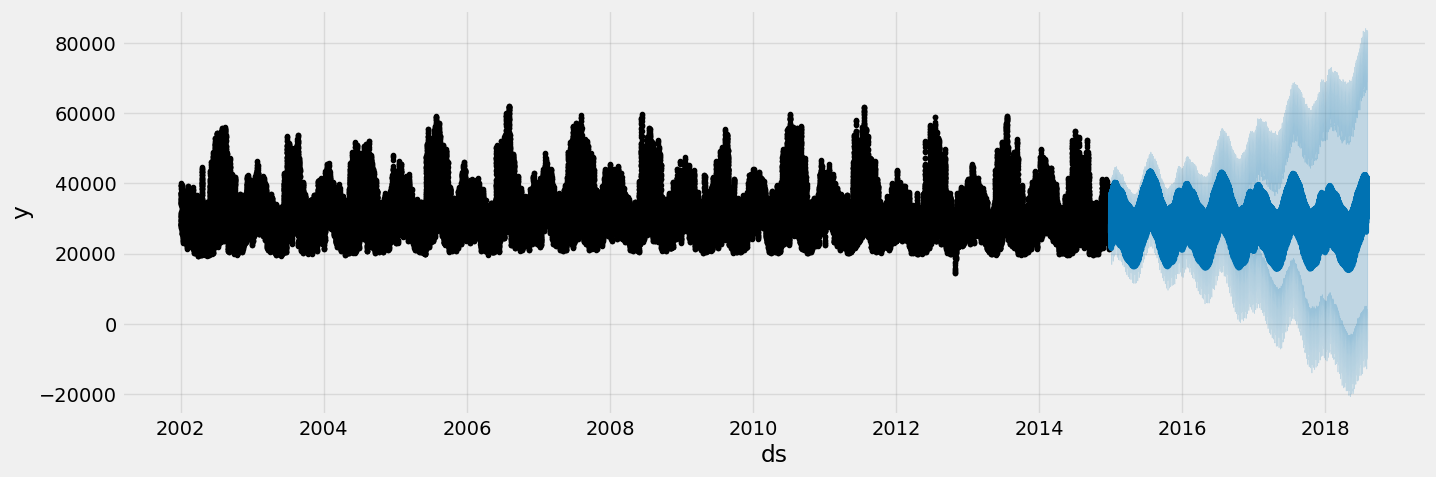

In [12]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()


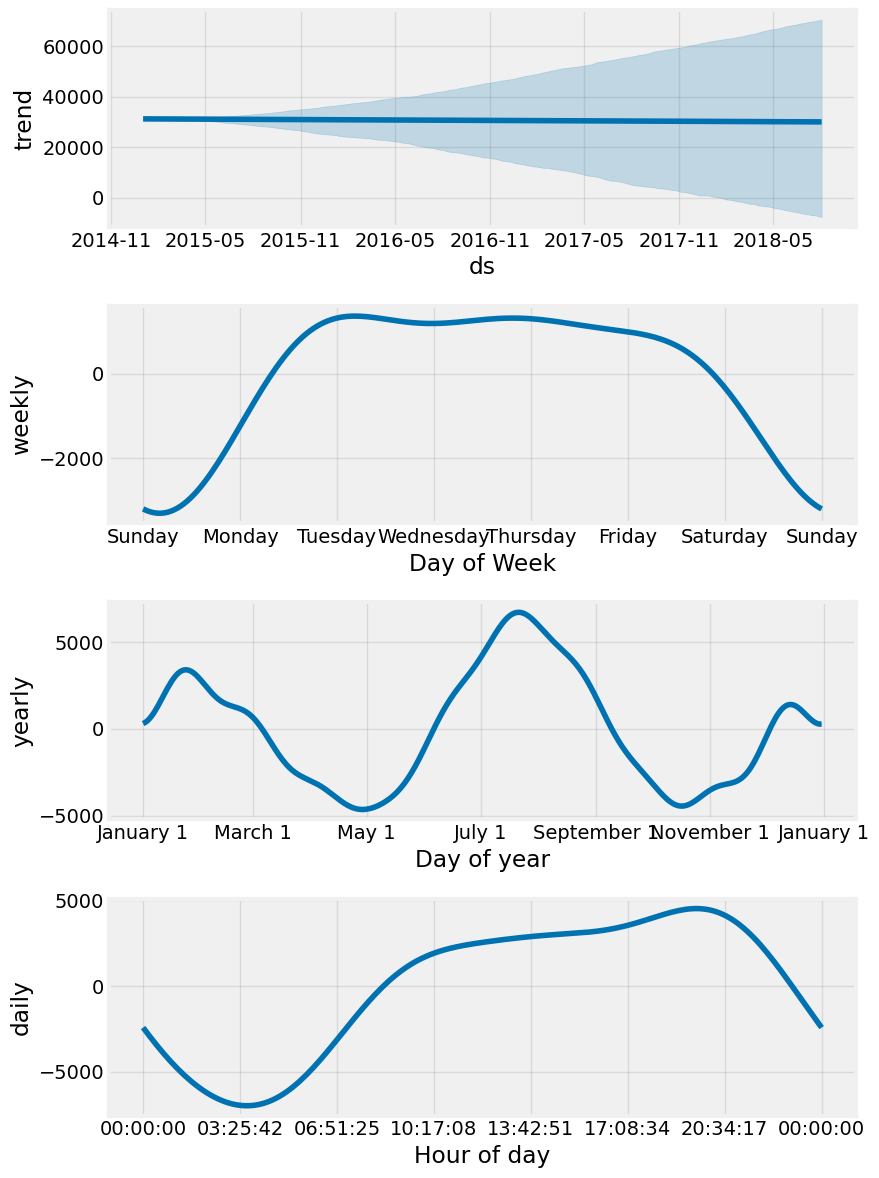

In [13]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

## Compare Forecast to Actuals

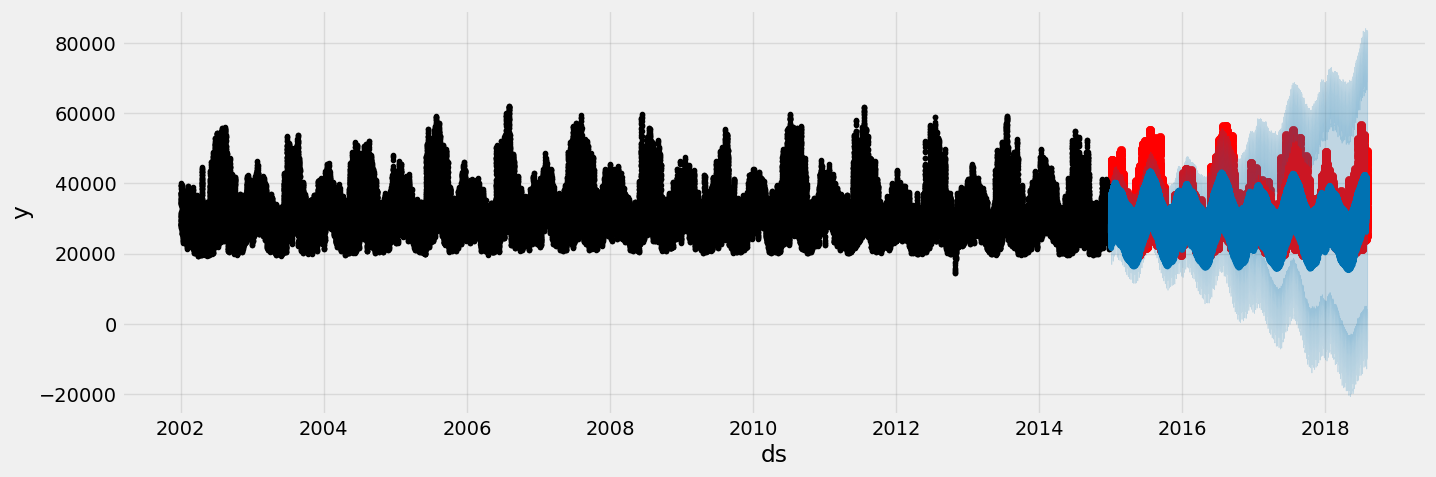

In [14]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

## Look at first month of predictions

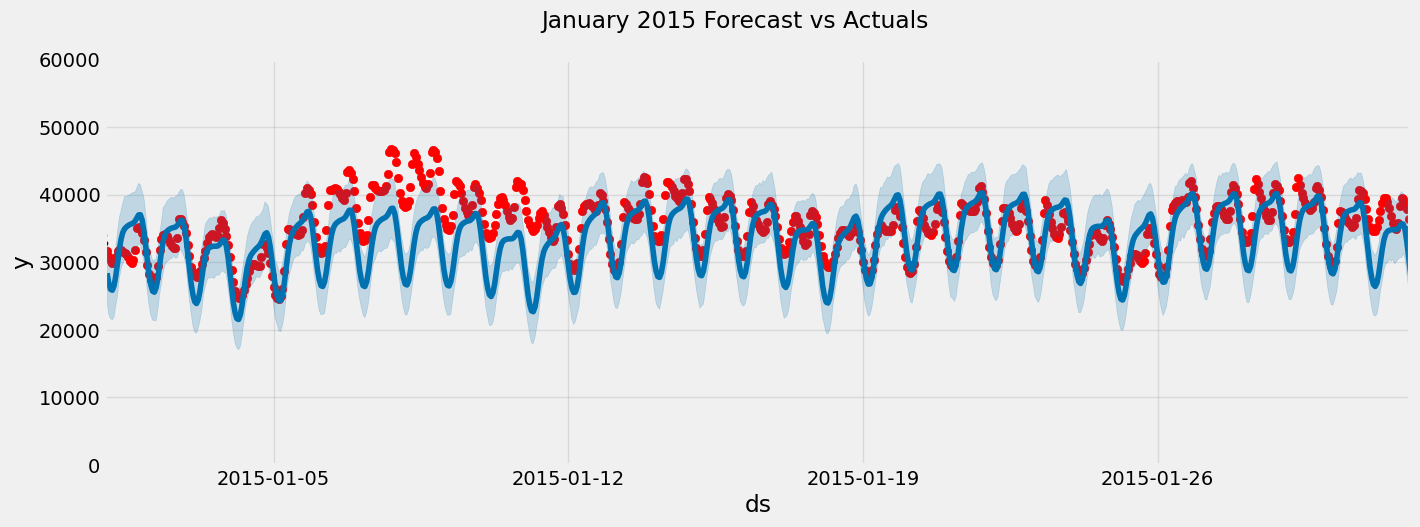

In [15]:

import datetime

# Your plotting code here
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Convert string dates to datetime objects
lower_bound = datetime.datetime.strptime('01-01-2015', '%m-%d-%Y')
upper_bound = datetime.datetime.strptime('02-01-2015', '%m-%d-%Y')

# Set the bounds using datetime objects
ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(0, 60000)
plt.suptitle('January 2015 Forecast vs Actuals')

plt.show() # This line is to display the plot if not already showing


## Single Week of Predictions

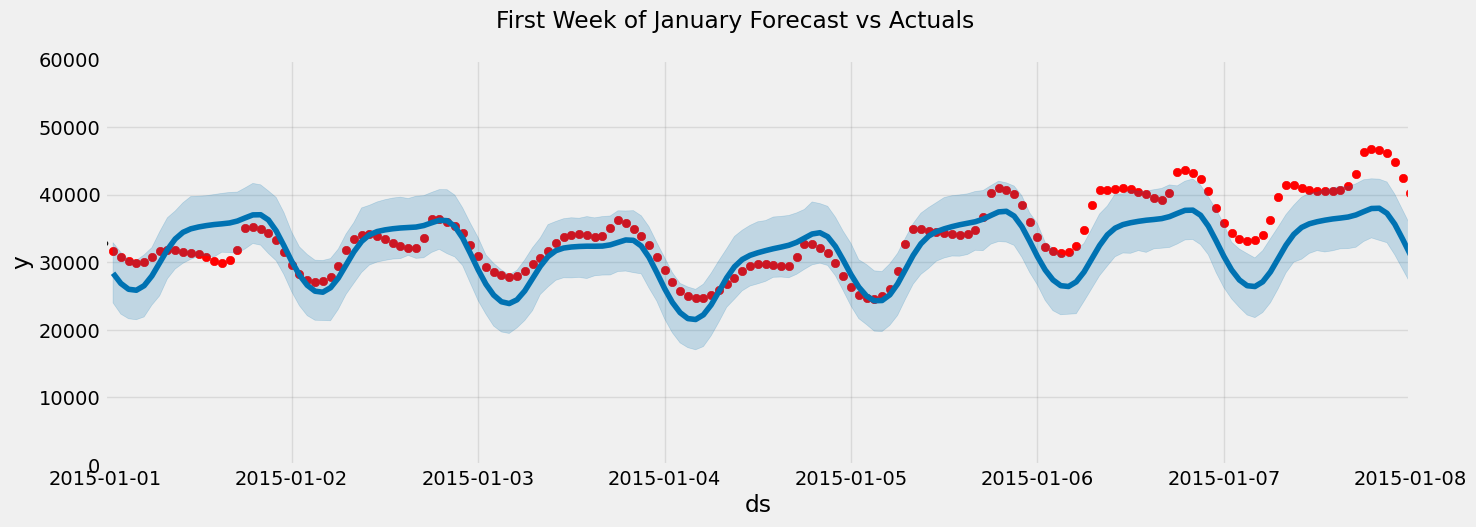

In [17]:
import datetime

# Your plotting code here
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Convert string dates to datetime objects
lower_bound = datetime.datetime.strptime('01-01-2015', '%m-%d-%Y')
upper_bound = datetime.datetime.strptime('01-08-2015', '%m-%d-%Y')

# Set the bounds using datetime objects
ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(0, 60000)
plt.suptitle('First Week of January Forecast vs Actuals')

plt.show() # This line is to display the plot if not already showing

## Error Metrics

In [18]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])


43813404.63323527

In [19]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5183.4263283888395

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])


16.508491433751185

## Adding Holidays

#### Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

#### We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [21]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(),
                              end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(),
                             end=pjme_test.index.max())

In [32]:
# Create a dataframe with holiday, ds columns
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2003-01-01 00:00:00,USFederalHoliday
1,2002-12-25 01:00:00,USFederalHoliday
2,2002-12-25 02:00:00,USFederalHoliday
3,2002-12-25 03:00:00,USFederalHoliday
4,2002-12-25 04:00:00,USFederalHoliday


In [33]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [34]:
holiday_df

,ds,holiday
0,2003-01-01 00:00:00,USFederalHoliday
1,2002-12-25 01:00:00,USFederalHoliday
2,2002-12-25 02:00:00,USFederalHoliday
3,2002-12-25 03:00:00,USFederalHoliday
4,2002-12-25 04:00:00,USFederalHoliday
...,...,...
3954,2018-01-01 19:00:00,USFederalHoliday
3955,2018-01-01 20:00:00,USFederalHoliday
3956,2018-01-01 21:00:00,USFederalHoliday
3957,2018-01-01 22:00:00,USFederalHoliday


In [35]:
# Setup and train model with holidays
model_with_holidays = prophet.Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'PJME_MW':'y'}))

13:32:00 - cmdstanpy - INFO - Chain [1] start processing
13:32:53 - cmdstanpy - INFO - Chain [1] done processing


## Predict with Holidays

In [36]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

## Plot Holiday Effect

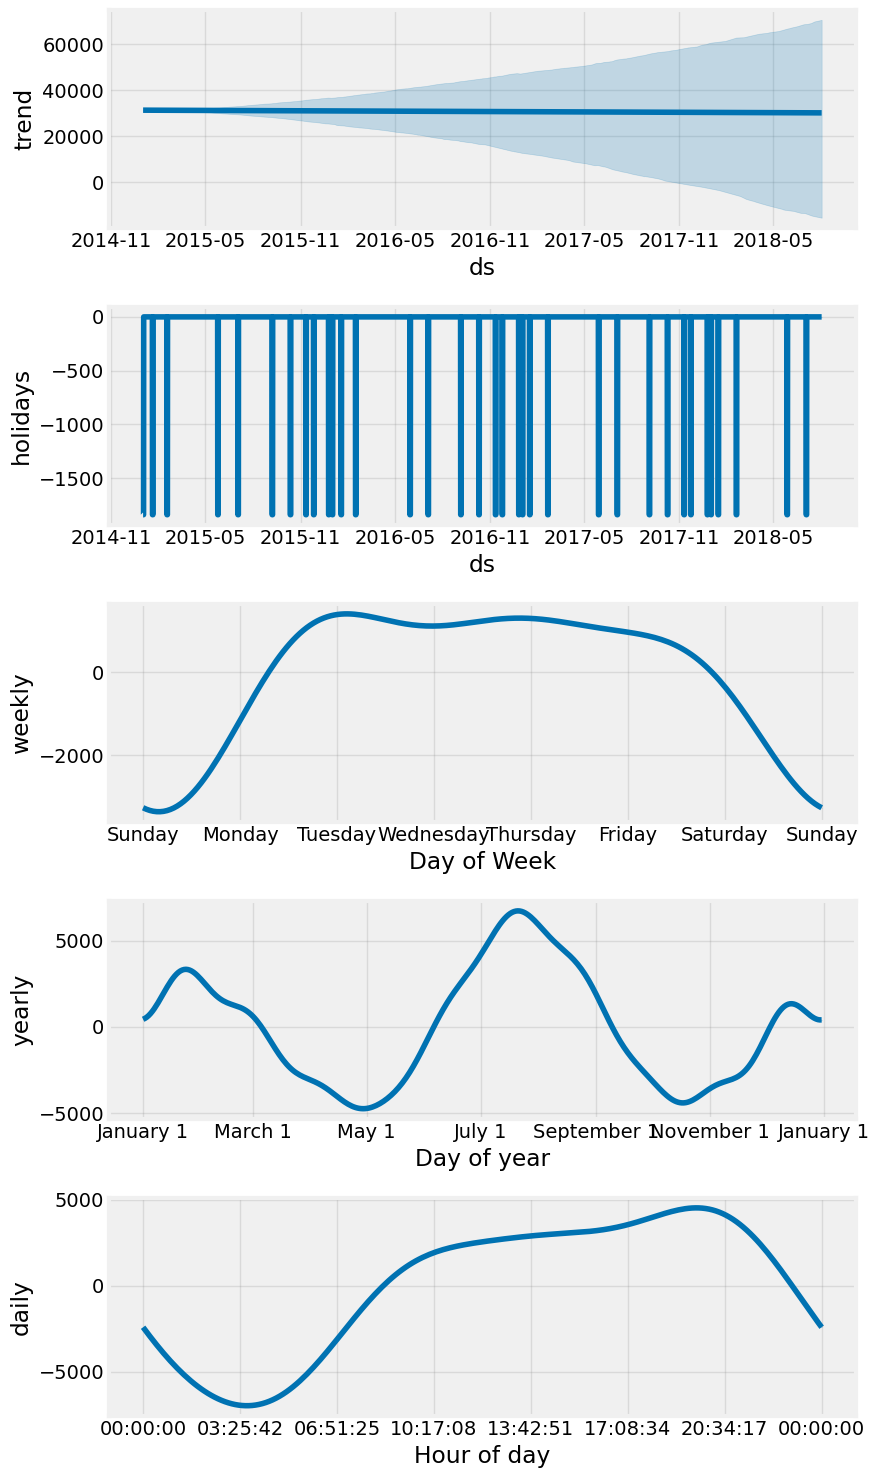

In [37]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

## Error Metrics with Holidays Added

In [38]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

43921755.72820914

In [39]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5191.103173434203

In [40]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.542297904382078

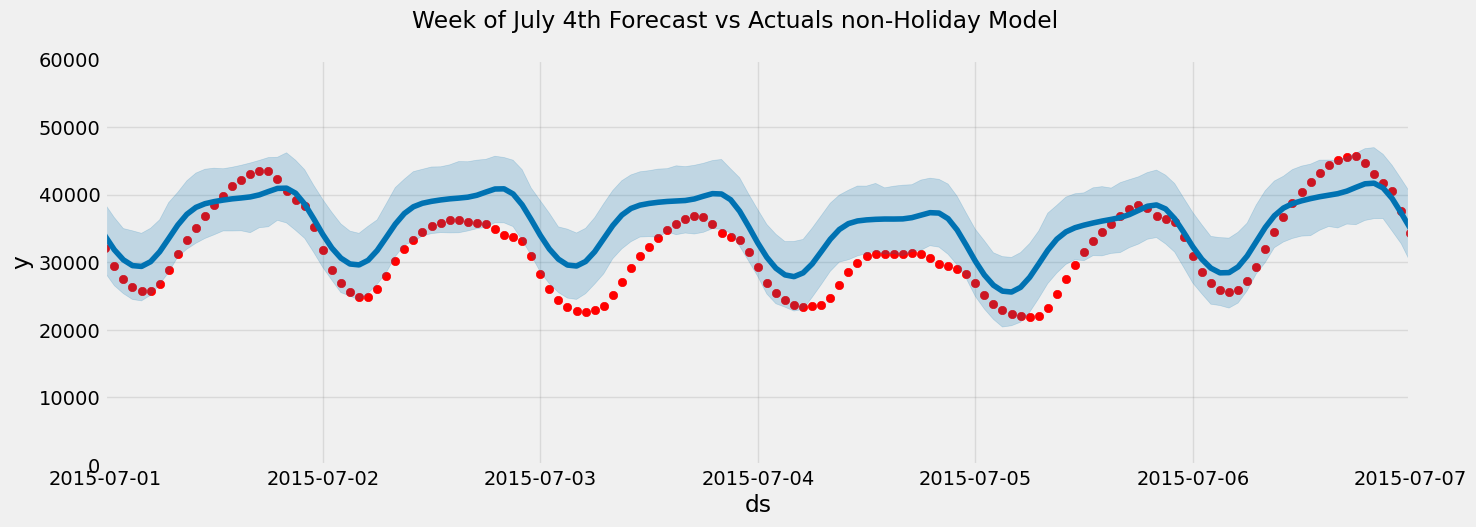

In [44]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
lower_bound = datetime.datetime.strptime('07-01-2015', '%m-%d-%Y')
upper_bound = datetime.datetime.strptime('07-07-2015', '%m-%d-%Y')

# Set the bounds using datetime objects
ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(0, 60000)
plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

plt.show() # This line is to display the plot if not already showing


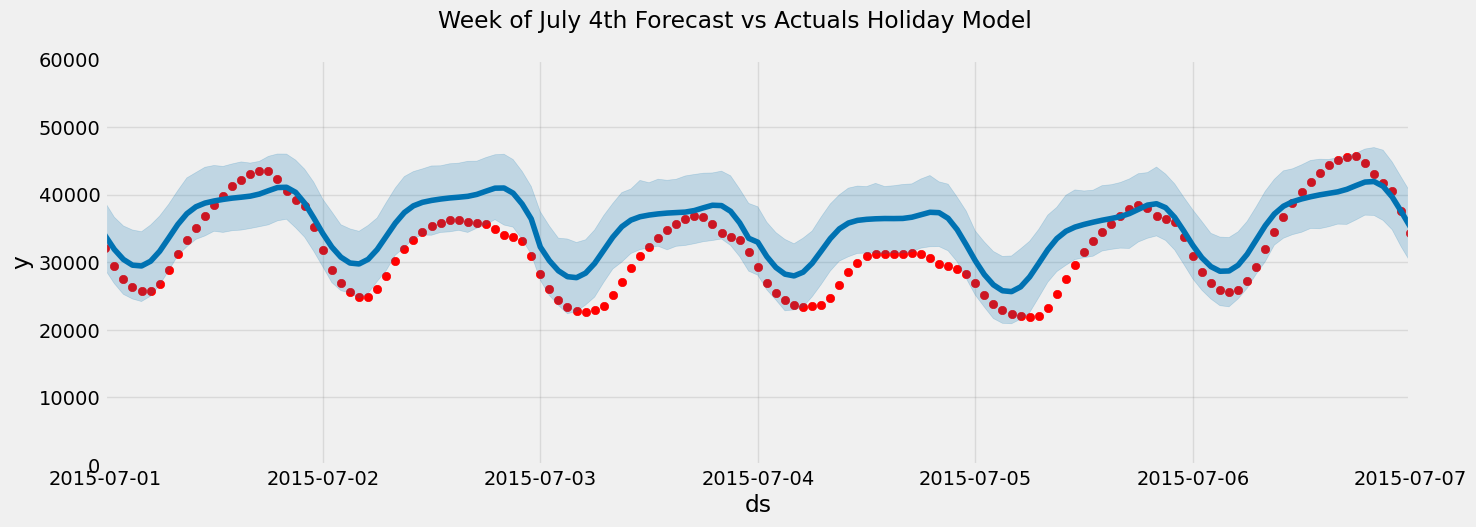

In [47]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
lower_bound = datetime.datetime.strptime('07-01-2015', '%m-%d-%Y')
upper_bound = datetime.datetime.strptime('07-07-2015', '%m-%d-%Y')

# Set the bounds using datetime objects
ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(0, 60000)
plt.suptitle('Week of July 4th Forecast vs Actuals Holiday Model')

plt.show()

## Compare Error for just 4th of July

In [48]:
jul4_test = pjme_test.query('Datetime >= 20160407 and Datetime < 20160408')
jul4_pred = pjme_test_fcst.query('ds >= 20160407 and ds < 20160408')
jul4_pred_holiday_model = pjme_test_fcst_with_hols.query('ds >= 20160407 and ds < 20160408')

In [49]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred['yhat'])

2155.1539597328006

In [50]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred_holiday_model['yhat'])

2152.9605132295633

## Error of all Holidays

In [51]:
holiday_list = holiday_df['ds'].tolist()

In [52]:
hols_test = pjme_test.query('Datetime in @holiday_list')
hols_pred = pjme_test_fcst.query('ds in @holiday_list')
hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')

In [53]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])

5223.747969824588

In [54]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred_holiday_model['yhat'])

5114.508738740212

## Identify Error by Holiday

In [55]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = pjme_test.query('Datetime in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = pjme_test_fcst.query('ds in @holiday_list')
    hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')

Holiday: January 01, 2015:    
 MAE (non-holiday model): 3090.0 
 MAE (Holiday Model): 2670.9 
 Diff 419.1
Holiday: January 19, 2015:    
 MAE (non-holiday model): 2413.3 
 MAE (Holiday Model): 2088.2 
 Diff 325.1
Holiday: February 16, 2015:    
 MAE (non-holiday model): 11118.1 
 MAE (Holiday Model): 12789.2 
 Diff -1671.1
Holiday: May 25, 2015:    
 MAE (non-holiday model): 1556.2 
 MAE (Holiday Model): 1620.0 
 Diff -63.8
Holiday: July 03, 2015:    
 MAE (non-holiday model): 6025.5 
 MAE (Holiday Model): 4305.1 
 Diff 1720.4
Holiday: September 07, 2015:    
 MAE (non-holiday model): 3851.7 
 MAE (Holiday Model): 4320.6 
 Diff -468.8
Holiday: October 12, 2015:    
 MAE (non-holiday model): 1582.1 
 MAE (Holiday Model): 1883.6 
 Diff -301.4
Holiday: November 11, 2015:    
 MAE (non-holiday model): 2041.3 
 MAE (Holiday Model): 1586.3 
 Diff 455.0
Holiday: November 26, 2015:    
 MAE (non-holiday model): 4660.6 
 MAE (Holiday Model): 3776.8 
 Diff 883.9
Holiday: December 25, 2015:    


## Plot Error of Each Forecast

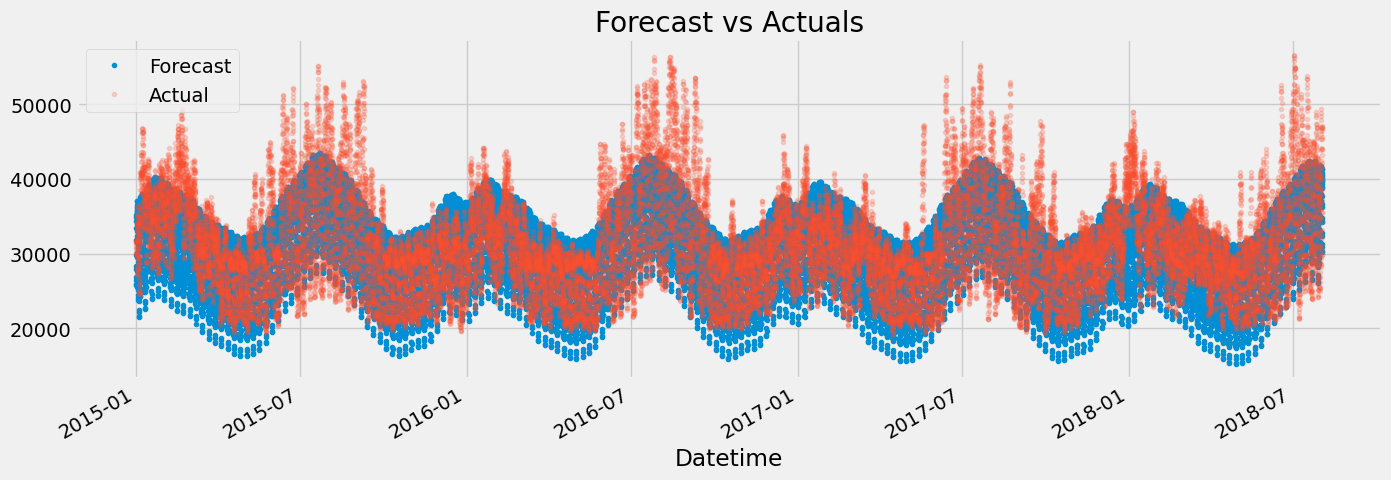

In [56]:
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
pjme_test['PJME_MW'].plot(ax=ax,
                          style='.',
                          lw=0,
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()

## Data Cleaning 

Data cleaning is a very important part of the forecasting process. If the input data contains garbage values, the forecast will use them when making predictions and could cause serious issues.

We notice in the training data that we have some bad measurements where the values are much less. Could these be causing the under forecasting? Lets try removing this bad data.


This plot shows the bad data highlighted in red.

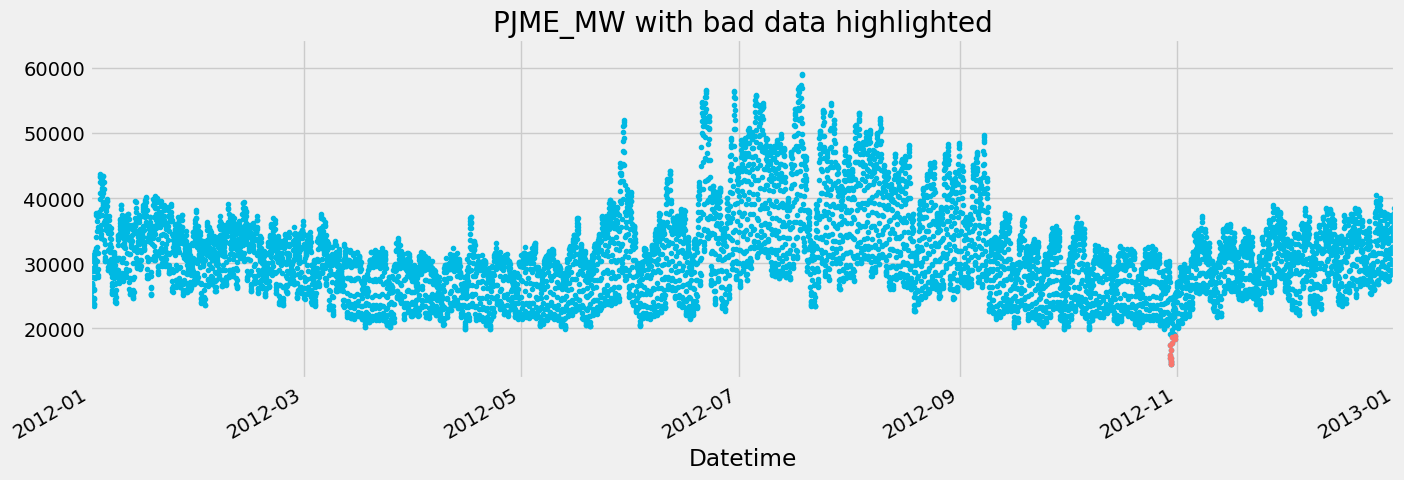

In [57]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('01-01-2012','01-01-2013')
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

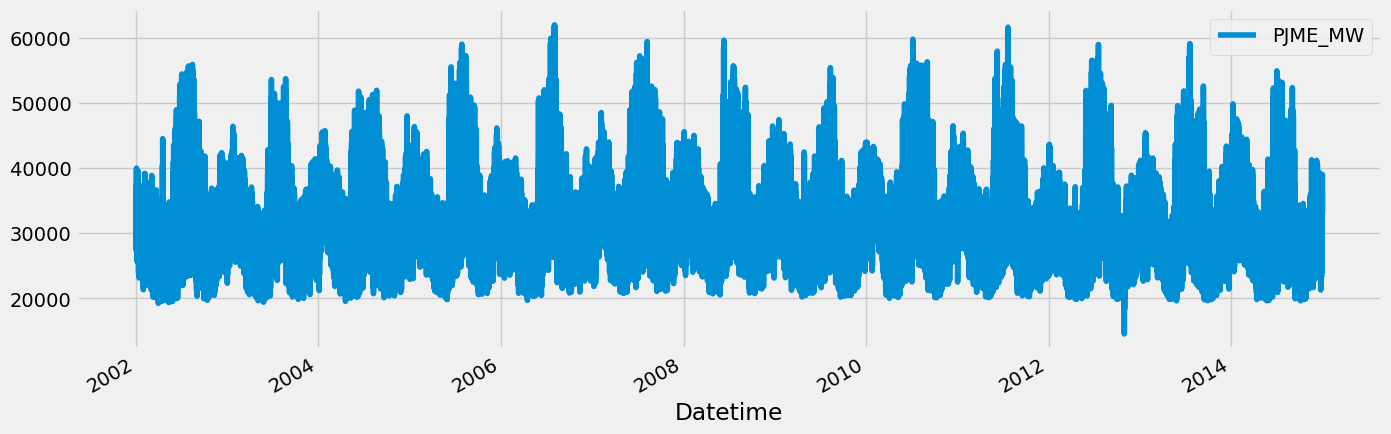

In [58]:
pjme_train.plot(figsize=(15, 5))
plt.show()

What caused this dip in energy demand? Hurricane Sandy! Check out this wikipedia article: https://en.wikipedia.org/wiki/List_of_major_power_outages#2012

On October 29–30, Hurricane Sandy brought high winds and coastal flooding to a large portion of the eastern United States, leaving an estimated 8 million customers without power. The storm, which came ashore near Atlantic City, New Jersey as a Category 1 hurricane, ultimately left scores of homes and businesses without power in New Jersey (2.7 million), New York (2.2 million), Pennsylvania (1.2 million), Connecticut (620,000), Massachusetts (400,000), Maryland (290,000), West Virginia (268,000), Ohio (250,000), and New Hampshire (210,000). Power outages were also reported in a number of other states, including Virginia, Maine, Rhode Island, Vermont, and the District of Columbia.

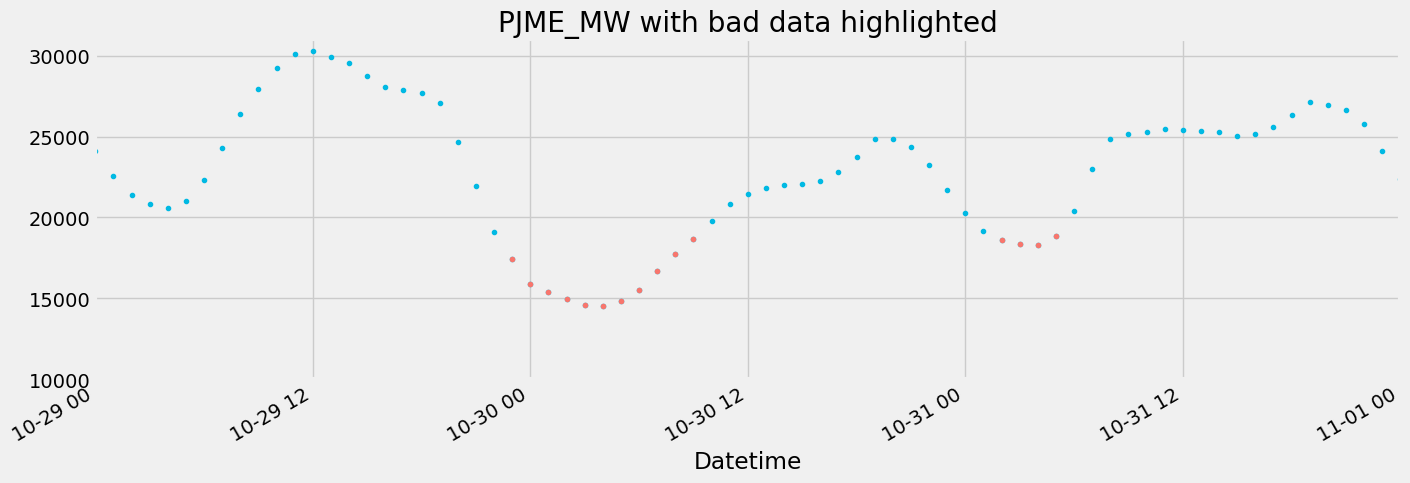

In [59]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('10-29-2012','11-01-2012'),
                     ylim=(10000, 31000)
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

In [62]:
# Clean Data
pjme_train['PJME_MW_clean'] = pjme_train['PJME_MW']
pjme_train.loc[pjme_train['PJME_MW'] < 19000, 'PJME_MW_clean'] = np.nan

# Train model on clean data
model = prophet.Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW_clean':'y'})
         )

# Predict on training set with clean model
pjme_test_fcst_clean = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

14:15:01 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing


After cleaning we see a slight improvement in score compared to the first model. More data cleaning, along with holidays could yield even better results. Give it a try!

In [63]:
mse_clean = mean_squared_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst_clean['yhat']
                              )
mae_clean = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                                y_pred=pjme_test_fcst_clean['yhat']
                               )
mape_clean = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                            y_pred=pjme_test_fcst_clean['yhat'])
print(f'Cleaned data model has MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

Cleaned data model has MSE 43862866.5817 - MAE 5185.2289 - MAPE 16.5025


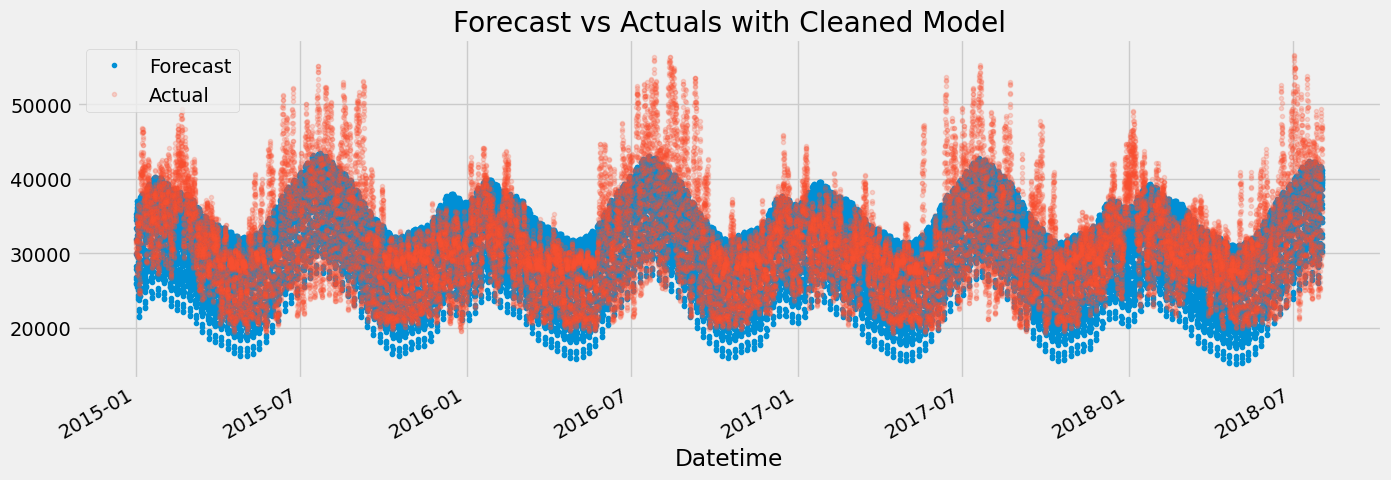

In [64]:
ax = pjme_test_fcst_clean.set_index('ds')['yhat'] \
    .plot(figsize=(15, 5), lw=0, style='.')
pjme_test['PJME_MW'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals with Cleaned Model')
plt.show()